In [1]:
# MCMurdo Analysis 
# UCSC 2023
# Liam Branch, Michelle Pichardo, Robert Johnson

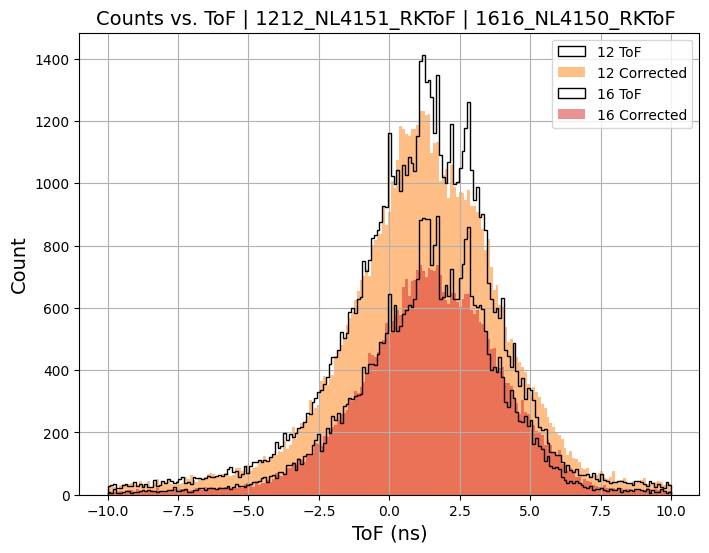

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

""" GLOBALS & CONSTANTS but why/how """
PARAMS = {'A':4317.5, 'B':0.0545, 'n':1.5691} # Original params from the best result 
# Others options
# PARAMS.update({'A':50000, 'n':2.55 }) # Liam's parameters playing around with algorithm 
PARAMS.update({'n':1.6298})  # OG params from 2nd best result 
# why: n: index of refraction inside of the scint, true value: 1.58
# These are fitted parameters using the TOF 

# Liam: knows if they are not working ~ visual inspect & Robert's analysis
# Fixing: unknown 

c = 29.9792 # cm/ns

PARAMS.update({'A':30}) 
# Param A: compound time error based on rising pulses 
# Higher pulses had more time walk vs low pulses 
# 

""" 
TOF correction Functions 

V1:  
    tof + A/( 1 + B * sqrt(T1) )  - A/( 1 + B * sqrt(T4) ) + n*(d4-d1)/c
V2:
    tof + n*(d4-d1)/c
"""
def tof_correction_v1(t1, t4, d1, d4, tof):
    return tof \
         + PARAMS['A']/(1+PARAMS['B']*np.sqrt(t1)) \
         - PARAMS['A']/(1+PARAMS['B']*np.sqrt(t4)) \
         + PARAMS['n']*(d4-d1) / c
         
def tof_correction_v2(d1,d4,tof):
    return tof + PARAMS['n']*(d4-d1) / c

""" PMT LOC : constants"""
# pmt locations
xPMT4=9.5*np.cos(np.radians(110))*2.54
yPMT4=9.5*np.sin(np.radians(110))*2.54
xPMT1=8.*np.cos(np.radians(-45))*2.54 
yPMT1=8.*np.sin(np.radians(-45))*2.54

""" LOAD DATA """
# load data & Select cut type
cut = 1 # 0:default, 1:without cut

# Name Parsing 
direc = 'data/'
prefix = 'Data4ToFCalibration_'
thresh_str = ['1212_NL4151_','1616_NL4150_']
default_pattern_recog = 'RK' # |xL0| < 4 cm
recog_without_position_cut = 'RKToF' # no cut on hit position in the first layer
#   - without cut should increase the numbers and/or quality of the track with T1, T4 trigger
end ='.txt'

CUT_CONDITION = [default_pattern_recog,recog_without_position_cut]
# Load 
df = pd.read_csv(direc+prefix+thresh_str[0]+CUT_CONDITION[cut]+end, sep=' ')
df2 = pd.read_csv(direc+prefix+thresh_str[1]+CUT_CONDITION[cut]+end, sep=' ')

df = df[(df['x1'] != -999.) & (df['ToF'] < 200)]
df2 = df2[(df2['x1'] != -999.) & (df2['ToF'] < 200)]


# Used in plot
fileName1 = thresh_str[0]+CUT_CONDITION[cut]
fileName2 = thresh_str[1]+CUT_CONDITION[cut]



""" 
Distance 
    d_ = sqrt( ( x1 - xPMT1 )^2 + ( y1 - yPMT1 )^2 ) 
    - files contain or should contain positions in cm 
"""
# Threshold of 12 distance from pmt   
dfd1 = np.sqrt(np.power(df['x1']-xPMT1,2)+np.power(df['y1']-yPMT1,2))
dfd4 = np.sqrt(np.power(df['x4']-xPMT4,2)+np.power(df['y4']-yPMT4,2))
# Threshold of 16 
df2d1 = np.sqrt(np.power(df2['x1']-xPMT1,2)+np.power(df2['y1']-yPMT1,2))
df2d4 = np.sqrt(np.power(df2['x4']-xPMT4,2)+np.power(df2['y4']-yPMT4,2))

""" Apply Correction Functions on distance calc 
    - Moving forward using v2 
"""
# Version 1 
# df_new_tof = tof_correction_v1(df['T1'], df['T4'], dfd1, dfd4, df['ToF'])
# df2_new_tof = tof_correction_v1(df2['T1'], df2['T4'], df2d1, df2d4, df2['ToF'])

# Version 2
df_new_tof = tof_correction_v2(dfd1, dfd4, df['ToF'])
df2_new_tof = tof_correction_v2(df2d1, df2d4, df2['ToF'])

""" PLOT """
# setup
fig0, ax0 = plt.subplots()
fig0.set_size_inches(8,6)
binning = np.linspace(-10,10,200)

# Threshold of 12
ax0.hist(df['ToF'], bins=binning, histtype='step', facecolor='none', edgecolor='k', label='12 ToF')
ax0.hist(df_new_tof, bins=binning, alpha=0.5, label='12 Corrected')

# Threshold of 16
ax0.hist(df2['ToF'], bins=binning, histtype='step', facecolor='none', edgecolor='k', label='16 ToF')
ax0.hist(df2_new_tof, bins=binning, alpha=0.5, label='16 Corrected')

# Labels 
ax0.legend()
ax0.grid()
ax0.set_title(f'Counts vs. ToF | {fileName1} | {fileName2} ', fontsize=14)
ax0.set_ylabel('Count',fontsize=14)
ax0.set_xlabel('ToF (ns)',fontsize=14)
plt.show()

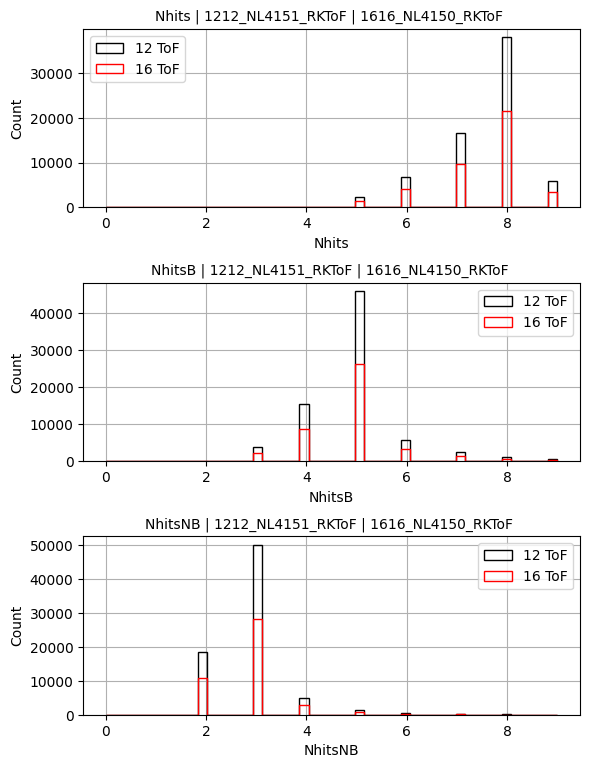

In [3]:
""" PLOT Nhits 
- Nhits: all
- NhitsB: bending plan, allowed to bend in the iteration
- NhitsNB: non bending plane

"""


# setup
fig, ax = plt.subplots(3,1)
fig.set_size_inches(6,8)
binning = np.linspace(0,9,50)

ax[0].hist(df['Nhits'], bins=binning, histtype='step', facecolor='none', edgecolor='k', label='12 ToF')
ax[0].hist(df2['Nhits'], bins=binning, histtype='step', facecolor='none', edgecolor='r', label='16 ToF') 
ax[0].legend()
ax[0].grid()
ax[0].set_title(f'Nhits | {fileName1} | {fileName2} ', fontsize=10)
ax[0].set_ylabel('Count',fontsize=10)
ax[0].set_xlabel('Nhits',fontsize=10)

ax[1].hist(df['NhitsB'], bins=binning, histtype='step', facecolor='none', edgecolor='k', label='12 ToF')
ax[1].hist(df2['NhitsB'], bins=binning, histtype='step', facecolor='none', edgecolor='r', label='16 ToF') 
ax[1].legend()
ax[1].grid()
ax[1].set_title(f'NhitsB | {fileName1} | {fileName2} ', fontsize=10)
ax[1].set_ylabel('Count',fontsize=10)
ax[1].set_xlabel('NhitsB',fontsize=10)

ax[2].hist(df['NhitsNB'], bins=binning, histtype='step', facecolor='none', edgecolor='k', label='12 ToF')
ax[2].hist(df2['NhitsNB'], bins=binning, histtype='step', facecolor='none', edgecolor='r', label='16 ToF') 
ax[2].legend()
ax[2].grid()
ax[2].set_title(f'NhitsNB | {fileName1} | {fileName2} ', fontsize=10)
ax[2].set_ylabel('Count',fontsize=10)
ax[2].set_xlabel('NhitsNB',fontsize=10)

fig.tight_layout()
fig.subplots_adjust(top=.93)
plt.show()

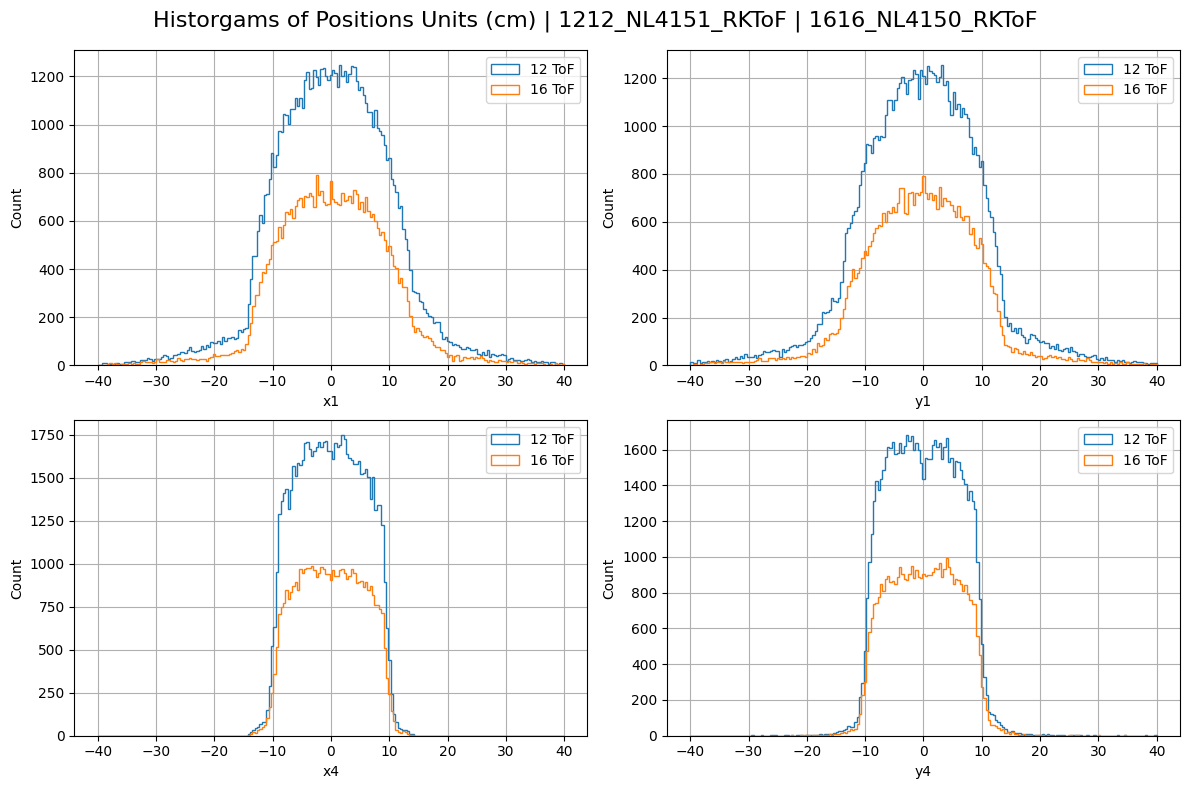

In [4]:
""" PLOT x1y1 x4y4"""
# setup
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,8)
binning = np.linspace(-40,40,200)

# Threshold of 12
ax[0,0].hist(df['x1'], bins=binning, histtype='step', facecolor='none', color = 'C0', label='12 ToF')
ax[0,1].hist(df['y1'], bins=binning, histtype='step', facecolor='none', color = 'C0', label='12 ToF')
ax[1,0].hist(df['x4'], bins=binning, histtype='step', facecolor='none', color = 'C0', label='12 ToF')
ax[1,1].hist(df['y4'], bins=binning, histtype='step', facecolor='none', color = 'C0', label='12 ToF')

# Threshold of 16
ax[0,0].hist(df2['x1'], bins=binning, histtype='step', facecolor='none', color = 'C1', label='16 ToF')
ax[0,1].hist(df2['y1'], bins=binning, histtype='step', facecolor='none', color = 'C1', label='16 ToF')
ax[1,0].hist(df2['x4'], bins=binning, histtype='step', facecolor='none', color = 'C1', label='16 ToF')
ax[1,1].hist(df2['y4'], bins=binning, histtype='step', facecolor='none', color = 'C1', label='16 ToF')

# Labels 
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

ax[0,0].set_ylabel('Count',fontsize=10)
ax[0,1].set_ylabel('Count',fontsize=10)
ax[1,0].set_ylabel('Count',fontsize=10)
ax[1,1].set_ylabel('Count',fontsize=10)

ax[0,0].set_xlabel('x1',fontsize=10)
ax[0,1].set_xlabel('y1',fontsize=10)
ax[1,0].set_xlabel('x4',fontsize=10)
ax[1,1].set_xlabel('y4',fontsize=10)

fig.tight_layout()
fig.subplots_adjust(top=.93)
fig.suptitle(f"Historgams of Positions Units (cm) | {fileName1} | {fileName2}", fontsize=16)
plt.show()

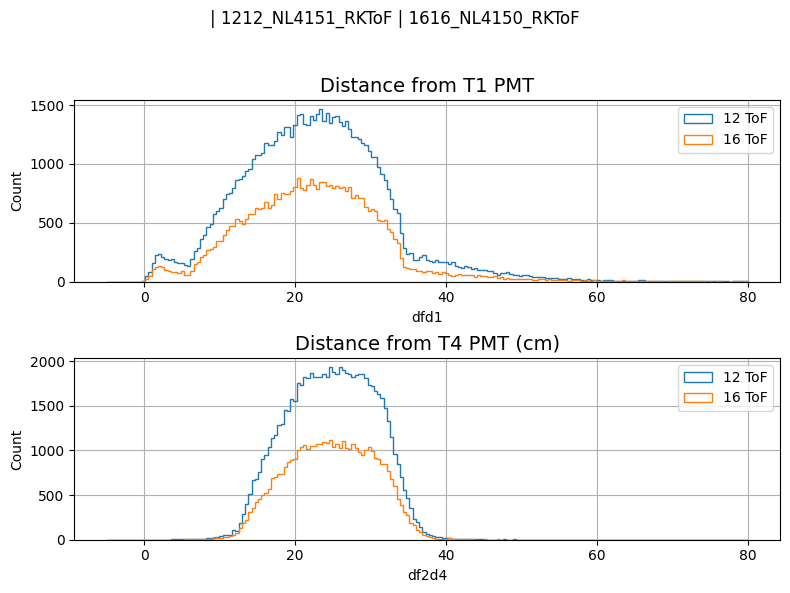

In [5]:
""" PLOT """
# setup
fig, ax = plt.subplots(2,1)
fig.set_size_inches(8,6)
binning = np.linspace(-5,80,200)

# Threshold of 12
ax[0].hist(dfd1, bins=binning, histtype='step', facecolor='none', color = 'C0', label='12 ToF')
ax[0].hist(df2d1, bins=binning, histtype='step', facecolor='none', color = 'C1', label='16 ToF')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('Count',fontsize=10)
ax[0].set_xlabel('dfd1',fontsize=10)
ax[0].set_title('Distance from T1 PMT',fontsize=14)


# Threshold of 16
ax[1].hist(dfd4, bins=binning, histtype='step', facecolor='none', color = 'C0', label='12 ToF')
ax[1].hist(df2d4, bins=binning, histtype='step', facecolor='none', color = 'C1', label='16 ToF')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('Count',fontsize=10)
ax[1].set_xlabel('df2d4',fontsize=10)
ax[1].set_title('Distance from T4 PMT (cm)',fontsize=14)

fig.suptitle(f"| {fileName1} | {fileName2}")
fig.tight_layout()
fig.subplots_adjust(top=.83)
plt.show()

In [6]:
""" First Glance """

import seaborn as sns
import statsmodels.api as sm
from scipy.stats import linregress

# Correlation Matrix 
df.corr()


dfd1_corrMatrix = np.corrcoef(df['ToF'], dfd1)
dfd1_lin = linregress(df['ToF'], dfd1)

dfd4_corrMatrix = np.corrcoef(df['ToF'], dfd4)
dfd4_lin = linregress(df['ToF'], dfd4)

df2d1_corrMatrix = np.corrcoef(df2['ToF'], df2d1)
df2d1_lin = linregress(df2['ToF'], df2d1)

df2d4_corrMatrix = np.corrcoef(df2['ToF'], df2d4)
df2d4_lin = linregress(df2['ToF'], df2d4)


print(dfd1_lin)
print(dfd4_lin)
print(df2d1_lin)
print(df2d4_lin)

LinregressResult(slope=-0.049557381907381355, intercept=23.108983290411857, rvalue=-0.02344749298393386, pvalue=1.1066705421922879e-10, stderr=0.007680314571829391, intercept_stderr=0.04643817137702487)
LinregressResult(slope=0.016933755643244904, intercept=24.76256237803294, rvalue=0.016757848579454393, pvalue=4.014389318254475e-06, stderr=0.003672489162446264, intercept_stderr=0.022205298951098035)
LinregressResult(slope=-0.10495199146303187, intercept=22.97474329819313, rvalue=-0.04165709501566158, pvalue=4.752257786444185e-18, stderr=0.012115001515280195, intercept_stderr=0.06151343618711189)
LinregressResult(slope=0.03351153763396116, intercept=24.67532500711157, rvalue=0.027454300939260264, pvalue=1.160279062539067e-08, stderr=0.005872447560019886, intercept_stderr=0.02981711787570417)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


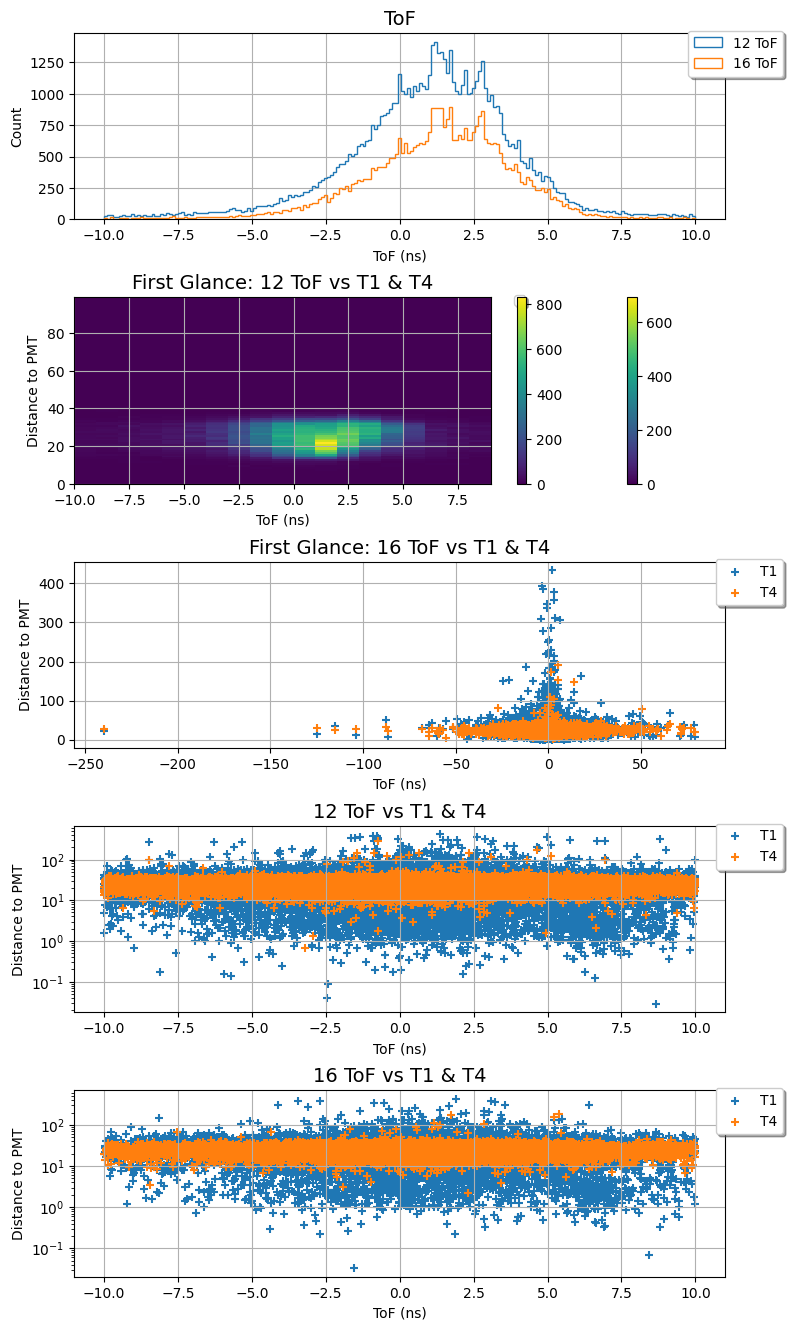

In [19]:
# TOF and dfdN are both series 

# Do not uncomment, this is moved to load data section
tof12 = df['ToF']# (101073,)
tof16 = df2['ToF'] # (58450,)

# dfd1  (101073,)
# dfd4  (101073,)
# df2d1 (58450,)
# df2d4 (58450,)

# shorten the range of data between -10,10

tof12_10 = tof12[(tof12 >= -10) & (tof12 <= 10)]
tof16_10 = tof16[(tof16 >= -10) & (tof16 <= 10)]

dfd1_10 = dfd1[(tof12 >= -10) & (tof12 <= 10)]
dfd4_10 = dfd4[(tof12 >= -10) & (tof12 <= 10)]

df2d1_10 = df2d1[(tof16 >= -10) & (tof16 <= 10)]
df2d4_10 = df2d4[(tof16 >= -10) & (tof16 <= 10)]

tofbin = np.linspace(-10,10,200)
distPMTbin = np.linspace(-5,80,200)


fig, ax = plt.subplots(5,1)
fig.set_size_inches(8,14)

ax[0].hist(tof12, bins=tofbin, histtype='step', facecolor='none', color = 'C0', label='12 ToF')
ax[0].hist(tof16, bins=tofbin, histtype='step', facecolor='none', color = 'C1', label='16 ToF')
ax[0].legend(bbox_to_anchor=(1.1, 1.05),fancybox=True, shadow=True)
ax[0].grid()
ax[0].set_title('ToF',fontsize=14)
ax[0].set_ylabel('Count',fontsize=10)
ax[0].set_xlabel('ToF (ns)',fontsize=10)

# ax[0,0].hist(dfd1, bins=distPMTbin, histtype='step', facecolor='none', color = 'C0', label='12 dist2PMT')
# ax[0,0].hist(df2d1, bins=distPMTbin, histtype='step', facecolor='none', color = 'C1', label='16 dist2PMT')
# ax[0,0].legend()
# ax[0,0].grid()
# ax[0,0].set_title('T1 to PMT')

# ax[1].hist(dfd4, bins=distPMTbin, histtype='step', facecolor='none', color = 'C0', label='12 dist2PMT')
# ax[1].hist(df2d4, bins=distPMTbin, histtype='step', facecolor='none', color = 'C1', label='16 dist2PMT')
# ax[1].legend()
# ax[1].grid()
# ax[1].set_title('T4 to PMT')

h1 = ax[1].hist2d(df['ToF'], dfd1, bins =[np.arange(-10,10,1), np.arange(0,100,1)], cmap =)
h2 = ax[1].hist2d(df['ToF'], dfd4, bins =[np.arange(-10,10,1), np.arange(0,100,1)])
fig.colorbar(h1[3], ax=ax[1])
fig.colorbar(h2[3], ax=ax[1])
# ax[1].set_xlim([-50, 50])
# ax[1].set_ylim([0, 100])
ax[1].legend(bbox_to_anchor=(1.1, 1.05),fancybox=True, shadow=True)
ax[1].grid()
ax[1].set_title('First Glance: 12 ToF vs T1 & T4',fontsize=14)
ax[1].set_ylabel('Distance to PMT',fontsize=10)
ax[1].set_xlabel('ToF (ns)',fontsize=10)

ax[2].scatter(df2['ToF'], df2d1, color = 'C0', label='T1', marker= '+')
ax[2].scatter(df2['ToF'], df2d4, color = 'C1', label='T4', marker= '+')
# ax[2].set_yscale('log')
ax[2].legend(bbox_to_anchor=(1.1, 1.05),fancybox=True, shadow=True)
ax[2].grid()
ax[2].set_title('First Glance: 16 ToF vs T1 & T4',fontsize=14)
ax[2].set_ylabel('Distance to PMT',fontsize=10)
ax[2].set_xlabel('ToF (ns)',fontsize=10)

ax[3].scatter(tof12_10, dfd1_10, color = 'C0', label='T1', marker= '+')
ax[3].scatter(tof12_10, dfd4_10, color = 'C1', label='T4', marker= '+')
ax[3].set_yscale('log')
ax[3].legend(bbox_to_anchor=(1.1, 1.05),fancybox=True, shadow=True)
ax[3].grid()
ax[3].set_title('12 ToF vs T1 & T4',fontsize=14)
ax[3].set_ylabel('Distance to PMT',fontsize=10)
ax[3].set_xlabel('ToF (ns)',fontsize=10)

ax[4].scatter(tof16_10, df2d1_10, color = 'C0', label='T1', marker= '+')
ax[4].scatter(tof16_10, df2d4_10, color = 'C1', label='T4', marker= '+')
ax[4].set_yscale('log')
ax[4].legend(bbox_to_anchor=(1.1, 1.05),fancybox=True, shadow=True)
ax[4].grid()
ax[4].set_title('16 ToF vs T1 & T4',fontsize=14)
ax[4].set_ylabel('Distance to PMT',fontsize=10)
ax[4].set_xlabel('ToF (ns)',fontsize=10)


fig.tight_layout()
fig.subplots_adjust(top=.93)
plt.show()

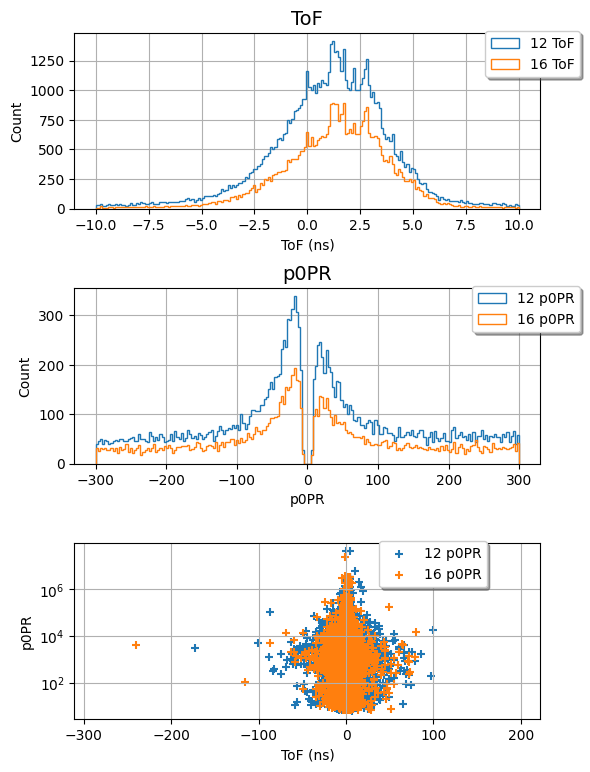

In [9]:
# TOF and dfdN are both series 

tof12 = df['ToF'] # (101073,)
tof16 = df2['ToF'] # (58450,)
p0PR12 = df['p0PR']
p0PR16 = df2['p0PR']


# shorten the range of data between -10,10

tof12_10 = tof12[(tof12 >= -10) & (tof12 <= 10)]
tof16_10 = tof16[(tof16 >= -10) & (tof16 <= 10)]

p0PR12_10 = p0PR12[(tof12 >= -10) & (tof12 <= 10)]
p0PR16_10 = p0PR12[(tof12 >= -10) & (tof12 <= 10)]


tofbin = np.linspace(-10,10,200)
p0PRbin = np.linspace(-300,300,200)


fig, ax = plt.subplots(3,1)
fig.set_size_inches(6,8)

ax[0].hist(tof12, bins=tofbin, histtype='step', facecolor='none', color = 'C0', label='12 ToF')
ax[0].hist(tof16, bins=tofbin, histtype='step', facecolor='none', color = 'C1', label='16 ToF')
ax[0].legend(bbox_to_anchor=(1.1, 1.05),fancybox=True, shadow=True)
ax[0].grid()
ax[0].set_title('ToF',fontsize=14)
ax[0].set_ylabel('Count',fontsize=10)
ax[0].set_xlabel('ToF (ns)',fontsize=10)

ax[1].hist(df['p0PR'], bins=p0PRbin, histtype='step', facecolor='none', color = 'C0', label='12 p0PR')
ax[1].hist(df2['p0PR'], bins=p0PRbin, histtype='step', facecolor='none', color = 'C1', label='16 p0PR')
# ax[1].set_yscale('log')
ax[1].legend(bbox_to_anchor=(1.1, 1.05),fancybox=True, shadow=True)
ax[1].grid()
ax[1].set_title('p0PR',fontsize=14)
ax[1].set_ylabel('Count',fontsize=10)
ax[1].set_xlabel('p0PR',fontsize=10)

ax[2].scatter(tof12, p0PR12, color = 'C0', label='12 p0PR', marker= '+')
ax[2].scatter(tof16, p0PR16, color = 'C1', label='16 p0PR', marker= '+')
ax[2].set_yscale('log')
ax[2].legend(bbox_to_anchor=(.9, 1.05),fancybox=True, shadow=True)
ax[2].grid()
ax[2].set_title('',fontsize=14)
ax[2].set_ylabel('p0PR',fontsize=10)
ax[2].set_xlabel('ToF (ns)',fontsize=10)



fig.tight_layout()
fig.subplots_adjust(top=.93)
plt.show()